# **Phase 2 Project Notebook - King County House Sales Dataset**

### Authors: Samantha, Ian, Sanjit

# Table of Contents

# Business Understanding

# Data Understanding and Preparation

First we shall install the necessary packages that we will need going forward with our exploration.

In [2]:
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
%matplotlib inline

# Statistical Models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

# Predictive Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

# Custom-made tools
import tools.helpers as th
import tools.data_preparation as dp
import tools.data_visualization as dv

### Importing the dataset and cleaning it

We import the csv file and run it through our first step of the cleaning process. <code>dp.initial_clean()</code> is a helper function can be found in the <code>"data_preparation.py"</code> file within the <code>"tools"</code> folder of this repository. 


What <code>dp.initial_clean()</code> does is: 

- Drop the <code>id</code> column. 
- Convert the <code>date</code> column values to DateTime format using <code>pd.to_datetime</code>.
- Convert the <code>'sqft_basement'</code> column values to float, coerce the '?' to NaN values.
- Mode fill <code>NaN</code> values in the columns: <code>waterfront</code>, <code>yr_renovated</code>, and <code>view</code>.

In [3]:
df = pd.read_csv('data/kc_house_data.csv')
final_df = dp.initial_clean(df)

Using <code>.info()</code> we take a look at what our dataset looks like after our initial clean. It can be seen here that there are no <code>null</code> values and the values in all columns except <code>date</code> are either stored in <code>float64</code> or <code>int64</code> format.

In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  float64       
 8   view           21597 non-null  float64       
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  float64       
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  float64       
 15  zipcode        2159

#### Plotting Histograms.

Let us now see if we can find anything interesting in the distributions of the columns in our dataset.

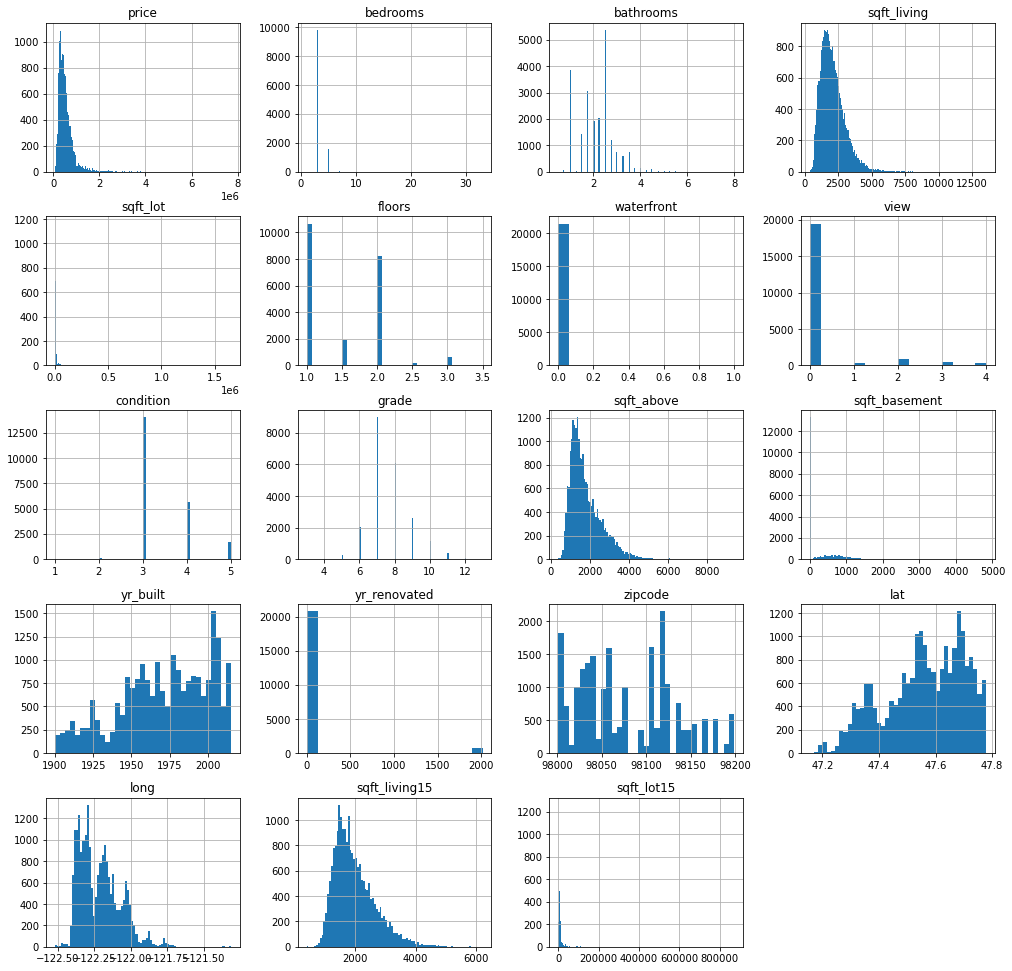

In [9]:
final_df.hist(figsize=(17, 17), bins='auto');

We can see from the above visualizations that our target column <code>price</code> is heavily skewed to the right. The same can be said about the columns <code>sqft_living</code> and <code>sqft_above</code> as well. The columns <code>long</code> and <code>sqft_living15</code> are right-skewed as well but seemingly not as much as the previously mentioned two columns.

#### add more here ^^^^

#### Finding correlations with  <code>price</code>.

Now we shall focus on our target <code>price</code> column and examine its relation with other columns in order to identify potential predictors for our first model.

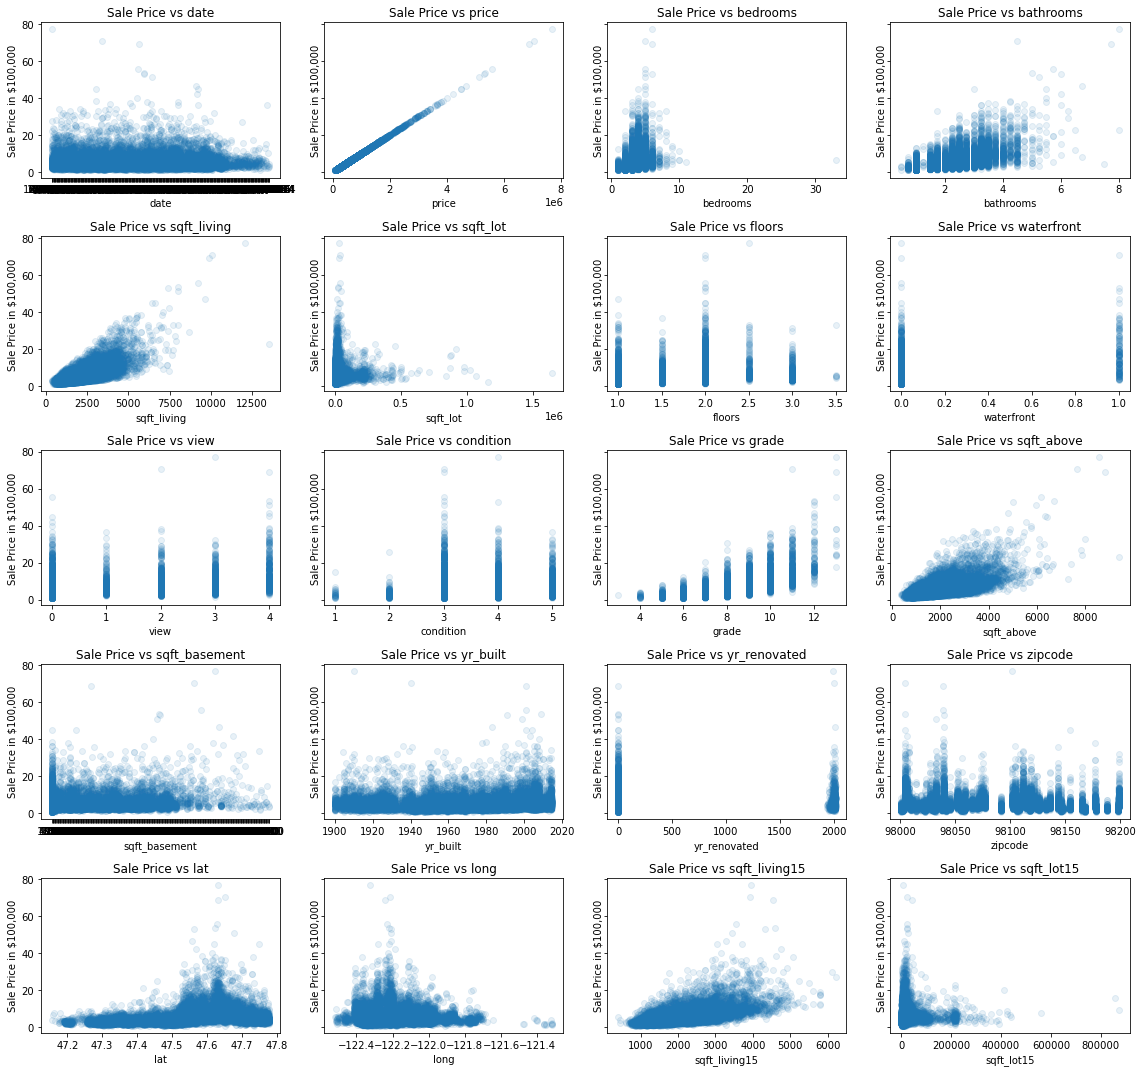

In [10]:
# SCATTERPLOTS???
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), final_df.columns):
    ax.scatter(df[column], df['price'] / 100_000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

At first glance, we can infer that our <code>price</code> data may have a positive correlation with the following columns:

- <code>sqft_living</code>
- <code>sqft_above</code>
- <code>sqft_living15</code>

The columns <code>floors</code>, <code>waterfront</code>, <code>view</code>, <code>condition</code>, <code>grade</code> and <code>yr_renovated</code> can be treated as categorical variables.


#### add more here ^^^^

#### Comparing Feature Multicollinearity

We use a custom function from the <code>data_visualization.py</code> file that takes a dataframe as an argument and returns a Seaborn visual of our features' multicollinearity. Every column from our dataset is compared against one another to identify how strong the correlation is between them. This can be helpful when selecting features that don't have strong multicollinearity, given how important this is for our predictive model to perform well.

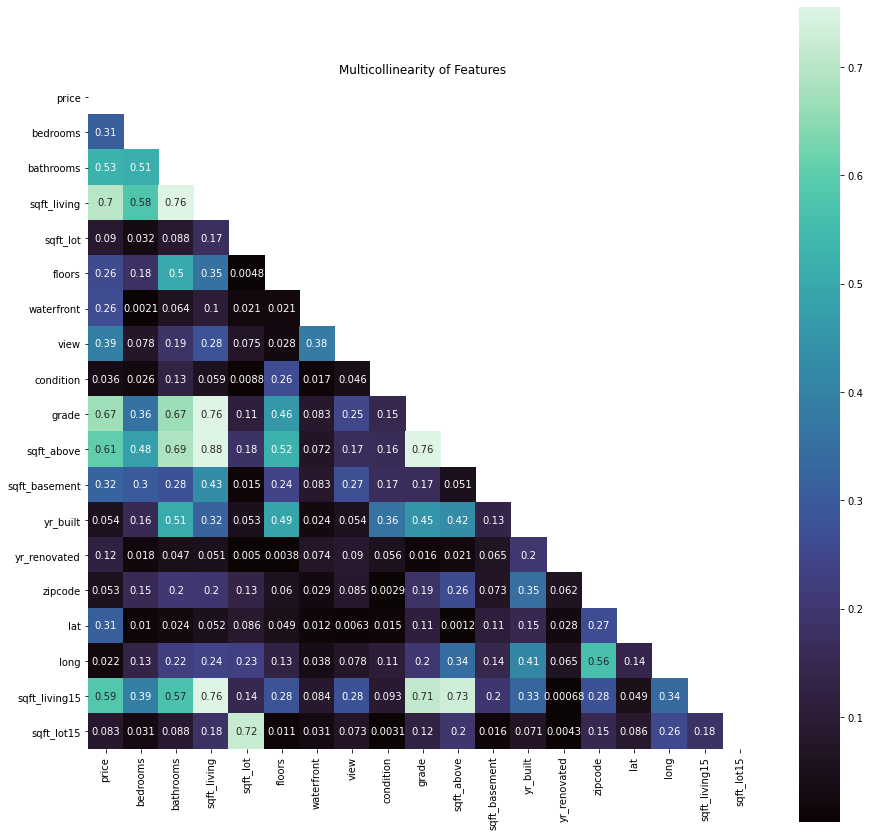

In [6]:
dv.corr_heatmap(final_df)

In [11]:
with open('data/king_county_zipcodes.geojson') as f:
    zipcode_geojson = json.load(f)

In [8]:
kc_zipcodes = final_df['zipcode'].unique()
zipcode_geojson['features'] = [feature for feature in zipcode_geojson['features'] if feature['properties']['ZIP'] in kc_zipcodes]

In [9]:
average_lat, average_long = final_df[['lat', 'long']].mean()
average_lat, average_long

(47.56009299439733, -122.21398249756845)

In [10]:
zipcode_avg_price = final_df.groupby('zipcode')[['price', 'lat', 'long']].mean().reset_index().sort_values('price', ascending=False)

zipcode_avg_price

zipcode         price        lat        long
24    98039  2.161300e+06  47.625840 -122.233540
3     98004  1.356524e+06  47.616183 -122.205189
25    98040  1.194874e+06  47.559846 -122.225592
48    98112  1.096239e+06  47.629619 -122.297866
41    98102  8.996077e+05  47.634591 -122.322250
..      ...           ...        ...         ...
61    98148  2.849086e+05  47.437437 -122.329316
0     98001  2.811949e+05  47.309106 -122.270704
20    98032  2.512962e+05  47.373556 -122.278848
64    98168  2.403284e+05  47.489700 -122.307877
1     98002  2.342840e+05  47.308780 -122.213357

[70 rows x 4 columns]

In [11]:
m = folium.Map(
    location=[average_lat, average_long],
    width='75%',
    length='75%',
    zoom_start=10
)

In [12]:
tooltips = folium.features.GeoJsonTooltip(
    fields=['ZIP']
)

In [13]:
highest_price, lat, long = zipcode_avg_price.iloc[0, 1:]

folium.Marker(
    location=[lat, long],
    tooltip=f"Average Price: ${highest_price:,.0f}"
).add_to(m);

In [14]:
choropleth = folium.Choropleth(
    geo_data=zipcode_geojson,
    data=zipcode_avg_price,
    columns=['zipcode', 'price'],
    key_on="feature.properties.ZIP",
    nan_fill_color=None,
    fill_color="YlOrRd",
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Sale Price ($)' 
)

choropleth.geojson.add_child(tooltips)
choropleth.add_to(m);

In [15]:
m

In [16]:
m.save('images/price_choropleth.png')

In [17]:
dp.add_distance(final_df)

In [18]:
final_df.head()

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0 2014-10-13  221900.0         3       1.00         1180      5650     1.0   
1 2014-12-09  538000.0         3       2.25         2570      7242     2.0   
2 2015-02-25  180000.0         2       1.00          770     10000     1.0   
3 2014-12-09  604000.0         4       3.00         1960      5000     1.0   
4 2015-02-18  510000.0         3       2.00         1680      8080     1.0   

   waterfront  view  condition  ...  sqft_above  sqft_basement  yr_built  \
0         0.0   0.0          3  ...        1180            0.0      1955   
1         0.0   0.0          3  ...        2170          400.0      1951   
2         0.0   0.0          3  ...         770            0.0      1933   
3         0.0   0.0          5  ...        1050          910.0      1965   
4         0.0   0.0          3  ...        1680            0.0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
0           0.0    98178  47.5112 -122.257           1340        5650   
1        1991.0    98125  47.7210 -122.319           1690        7639   
2           0.0    98028  47.7379 -122.233           2720        8062   
3           0.0    98136  47.5208 -122.393           1360        5000   
4           0.0    98074  47.6168 -122.045           1800        7503   

   dist_from_center  
0          0.117016  
1          0.127902  
2          0.112061  
3          0.190947  
4          0.188757  

[5 rows x 21 columns]

In [19]:
th.predictor_corrs(final_df)

cc
pairs                                 
(sqft_living, sqft_above)     0.876448
(grade, sqft_living)          0.762779
(sqft_living, sqft_living15)  0.756402
(sqft_above, grade)           0.756073
(bathrooms, sqft_living)      0.755758
(sqft_above, sqft_living15)   0.731767
(sqft_lot, sqft_lot15)        0.718204
(sqft_living15, grade)        0.713867
(price, sqft_living)          0.701917
(sqft_above, bathrooms)       0.686668
(grade, price)                0.667951
(grade, bathrooms)            0.665838
(lat, dist_from_center)       0.643657
(price, sqft_above)           0.605368

# Modeling

## Baseline

## Simple Linear Regression

In [20]:
#simple model comparing sqft_living with price
y = final_df['price']
X = final_df['sqft_living']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:37:12   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Multiple Linear Regression

In [21]:
# creating a new dataframe that removes colinear columns
df_test = final_df.drop(columns=[
    'date',
    'sqft_above', 
    'grade', 
    'sqft_living15', 
    'sqft_lot15', 
    'sqft_lot', 
    'bathrooms',
    'sqft_basement',
])
df_test.head()

price  bedrooms  sqft_living  floors  waterfront  view  condition  \
0  221900.0         3         1180     1.0         0.0   0.0          3   
1  538000.0         3         2570     2.0         0.0   0.0          3   
2  180000.0         2          770     1.0         0.0   0.0          3   
3  604000.0         4         1960     1.0         0.0   0.0          5   
4  510000.0         3         1680     1.0         0.0   0.0          3   

   yr_built  yr_renovated  zipcode      lat     long  dist_from_center  
0      1955           0.0    98178  47.5112 -122.257          0.117016  
1      1951        1991.0    98125  47.7210 -122.319          0.127902  
2      1933           0.0    98028  47.7379 -122.233          0.112061  
3      1965           0.0    98136  47.5208 -122.393          0.190947  
4      1987           0.0    98074  47.6168 -122.045          0.188757

In [22]:
# set X and y variables 
X = pd.DataFrame(df_test.drop('price', axis=1))
y = df_test.price

# pass variables into train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

In [23]:
lr = LinearRegression()

In [24]:
lr.fit(X_train, y_train)

LinearRegression()

In [25]:
lr.score(X_train, y_train)

0.6831030096375835

In [26]:
lr.score(X_test, y_test)

0.6808331998987343

## MLR with Polynomial Features

In [27]:
# log transform continuous variables
to_log = ['price', 'sqft_living', 'dist_from_center', 'lat']
th.log_transform(df_test, to_log)
# normalize continuous variables
to_log_2 = ['price', 'sqft_living', 'dist_from_center', 'lat']
th.normalize(df_test, to_log_2)

In [28]:
# fit 2 into polynomial features
poly_2 = PolynomialFeatures(2)

# set X and y variables 
X = pd.DataFrame(
            poly_2.fit_transform(df_test.drop('price', axis=1))
                      )
y = df_test.price

# pass variables into train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

In [29]:
display(X_train.head(2))
display(X_test.head(2))

0    1         2    3    4    5    6       7    8        9   ...  \
6243  1.0  4.0 -0.656140  2.0  0.0  0.0  4.0  1972.0  0.0  98144.0  ...   
8986  1.0  3.0 -0.672568  1.0  0.0  2.0  4.0  1980.0  0.0  98045.0  ...   

                81            82            83             84        85  \
6243  9.632245e+09   8358.195189 -1.200174e+07 -129403.414332  0.007253   
8986  9.612822e+09 -44928.002816 -1.193904e+07  191901.599203  0.209983   

             86        87            88          89        90  
6243 -10.414275 -0.112287  14954.110369  161.236095  1.738457  
8986  55.800172 -0.896902  14828.176441 -238.340044  3.830948  

[2 rows x 91 columns]

0    1         2    3    4    5    6       7    8        9   ...  \
3686   1.0  3.0 -1.898915  1.0  0.0  0.0  3.0  1945.0  0.0  98146.0  ...   
10247  1.0  3.0 -0.544238  1.0  0.0  0.0  4.0  1940.0  0.0  98115.0  ...   

                 81            82            83            84        85  \
3686   9.632637e+09 -40296.330469 -1.200875e+07  14379.394918  0.168572   
10247  9.626553e+09  96604.765480 -1.200182e+07 -57544.279096  0.969452   

               86        87            88         89        90  
3686    50.236360 -0.060154  14970.990736 -17.926408  0.021465  
10247 -120.441129 -0.577471  14963.160976  71.742816  0.343980  

[2 rows x 91 columns]

In [30]:
lr = LinearRegression()

In [31]:
lr.fit(X_train, y_train)

LinearRegression()

In [32]:
lr.score(X_train, y_train)

0.8231912233866743

In [33]:
lr.score(X_test, y_test)

0.7865428016644866

In [34]:
# gradient boost regressor using the df_test
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(loss = 'ls', learning_rate = 0.2, 
                                         n_estimators = 400, max_depth = 5, min_samples_split = 2,)

In [35]:
clf.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=400)

In [36]:
clf.score(X_train, y_train)

0.9636375143177839

In [37]:
clf.score(X_test, y_test)

0.8752248318237089

In [38]:
# dropping long, keeping lat and dist_from_center
df_test2 = final_df.drop(columns=[
    'date',
    'sqft_above', 
    'grade', 
    'sqft_living15', 
    'sqft_lot15', 
    'sqft_lot', 
    'bathrooms',
    'sqft_basement',
    'long'
])
df_test2.head()

price  bedrooms  sqft_living  floors  waterfront  view  condition  \
0  221900.0         3         1180     1.0         0.0   0.0          3   
1  538000.0         3         2570     2.0         0.0   0.0          3   
2  180000.0         2          770     1.0         0.0   0.0          3   
3  604000.0         4         1960     1.0         0.0   0.0          5   
4  510000.0         3         1680     1.0         0.0   0.0          3   

   yr_built  yr_renovated  zipcode      lat  dist_from_center  
0      1955           0.0    98178  47.5112          0.117016  
1      1951        1991.0    98125  47.7210          0.127902  
2      1933           0.0    98028  47.7379          0.112061  
3      1965           0.0    98136  47.5208          0.190947  
4      1987           0.0    98074  47.6168          0.188757

In [39]:
to_log_ = ['price', 'sqft_living', 'dist_from_center', 'lat']
th.log_transform(df_test2, to_log)
to_log_2_ = ['price', 'sqft_living', 'dist_from_center', 'lat']
th.normalize(df_test2, to_log_2)

In [40]:
poly_2 = PolynomialFeatures(2)

X2 = pd.DataFrame(
            poly_2.fit_transform(df_test2.drop('price', axis=1))
                      )

y2 = df_test2.price

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, 
                                                    y2,
                                                    test_size=0.2,
                                                    random_state=42
)

In [41]:
lr.fit(X2_train, y2_train)

LinearRegression()

In [42]:
lr.score(X2_train, y2_train)

0.8117325530450846

In [43]:
lr.score(X2_test, y2_test)

0.7835685708525914

In [ ]:
# Temp Note: if we drop 'long' we get a slightly smaller r squared (.003) for test
# and a smaller r squared for training data (less overfit)
# not sure which final model to keep